# Goals for Script
- Load the .npy files in a way that preserves their folder's structure (test, train, and groups within each)
- add labels based on the folder structure

After that 
- build model
- train model

In [107]:
import os 

type1path = '/Users/maycaj/Documents/Hyperspectral-Imaging_II/Lipstick Input/Train/Lipstick 1/'
type2path = '/Users/maycaj/Documents/Hyperspectral-Imaging_II/Lipstick Input/Train/Lipstick 2/'
type3path = '/Users/maycaj/Documents/Hyperspectral-Imaging_II/Lipstick Input/Train/Lipstick 3/'

def FindFilepaths(directory):
    filepaths = []
    for dirpath, dirnames, filenames in os.walk(directory):
        for filename in filenames:
            filepaths.append(directory + filename)
    return filepaths

type1paths = FindFilepaths(type1path)
type2paths = FindFilepaths(type2path)
type3paths = FindFilepaths(type3path)


# Now, Load data 

Tried but didn't work:
- torchvision.datasets.ImageFolder
- torchvision.datasets.DatasetFolder

In [108]:
import numpy as np
test_filepath = '/Users/maycaj/Documents/Hyperspectral-Imaging_II/Lipstick Input/Train/Lipstick 1/Lipstick type 1 image 1.npy'
test = np.load(test_filepath)
def read_npy(filepath):
    file = np.load(filepath)
    return file

In [109]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class CubeDataset(Dataset):
    def __init__(self, file_paths, transform=None):
        self.file_paths = file_paths

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        # We only load the images using readcube when it is needed so this is lazy loading. If I have issues with memory I can implement a cache for subsequent access https://discuss.pytorch.org/t/best-practice-to-cache-the-entire-dataset-during-first-epoch/19608
        cube_path = self.file_paths[idx]
        # Custom code to read .cube format image
        cube_image = read_npy(cube_path)
        cube_image = np.array(cube_image)
        # Convert cube image to numpy array and then to PyTorch tensor
        cube_tensor = torch.from_numpy(cube_image).float()
        return cube_tensor

# Example usage
custom_dataset = CubeDataset(type1paths)

# Create DataLoader for batching and shuffling
data_loader = torch.utils.data.DataLoader(custom_dataset, batch_size=32, shuffle=True)


## Visualize to see if the Dataloader worked



torch.Size([3, 696, 520, 128])
Random_idx: 2


Text(0.5, 1.0, 'Gray Image –\xa0Masked')

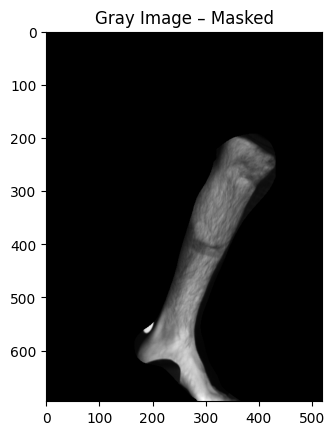

In [110]:
import matplotlib.pyplot as plt

# Check out what's inside the training dataloader
train_features_batch = next(iter(data_loader)) # ___ what do next and iter do?
print(train_features_batch.shape)
torch.manual_seed(6)
# Find a random index to display
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img = train_features_batch[random_idx]
print(f"Random_idx: {random_idx}")
fig, ax = plt.subplots()
ax.imshow(img[:, :, 49:50], cmap='gray')
ax.set_title('Gray Image – Masked')

# **Option 2:** Loading Image Data with a Custom Dataset
# **5.1**: Create a helper function to get class names
Reference: https://www.learnpytorch.io/04_pytorch_custom_datasets/#5-option-2-loading-image-data-with-a-custom-dataset

In [111]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List


In [112]:
from pathlib import Path
image_path = Path('/Users/maycaj/Documents/Hyperspectral-Imaging_II/Lipstick Input')


### Test to see if we can get classes from folder names

In [113]:
# Setup path for target directory
target_directory = '/Users/maycaj/Documents/Hyperspectral-Imaging_II/Lipstick Input/Train'
print(f"Target directory: {target_directory}")

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(image_path / "train"))])
print(f"Class names found: {class_names_found}")

Target directory: /Users/maycaj/Documents/Hyperspectral-Imaging_II/Lipstick Input/Train
Class names found: ['.DS_Store', 'Lipstick 1', 'Lipstick 2', 'Lipstick 3']


In [114]:
# Make function to find classes in target directory
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """Finds the class folder names in a target directory.
    
    Assumes target directory is in standard image classification format.

    Args:
        directory (str): target directory to load classnames from.

    Returns:
        Tuple[List[str], Dict[str, int]]: (list_of_class_names, dict(class_name: idx...))
    
    Example:
        find_classes("food_images/train")
        >>> (["class_1", "class_2"], {"class_1": 0, ...})
    """
    # 1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    
    # 2. Raise an error if class names not found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")
        
    # 3. Create a dictionary of index labels (computers prefer numerical rather than string labels)
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

In [115]:
train_dir = image_path / "train"
print(train_dir)
find_classes(train_dir)

/Users/maycaj/Documents/Hyperspectral-Imaging_II/Lipstick Input/train


(['Lipstick 1', 'Lipstick 2', 'Lipstick 3'],
 {'Lipstick 1': 0, 'Lipstick 2': 1, 'Lipstick 3': 2})

___ left off at 5.2
https://www.learnpytorch.io/04_pytorch_custom_datasets/#52-create-a-custom-dataset-to-replicate-imagefolder


# **5.2** Create a custom `Dataset` to replicate `ImageFolder`

I have placed comments where I have modified the script

In [116]:
# Write a custom dataset class (inherits from torch.utils.data.Dataset)
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
    
    # 2. Initialize with a targ_dir and transform (optional) parameter
    def __init__(self, targ_dir: str, transform=None) -> None:
        
        # 3. Create class attributes
        # Get all image paths
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.npy")) # modified from '*/*.jpg'
        # Setup transforms
        self.transform = transform
        # Create classes and class_to_idx attributes
        self.classes, self.class_to_idx = find_classes(targ_dir)

    # 4. Make function to load images
    def load_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.paths[index]
        image = np.load(image_path) # modified from opening a PNG file
        #change from [696, 520, 128] [width, height, channels] to [channels, height, width]
        image = np.transpose(image, (2, 1, 0))
        return image
    
    # 5. Overwrite the __len__() method (optional but recommended for subclasses of torch.utils.data.Dataset)
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.paths)
    
    # 6. Overwrite the __getitem__() method (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        "Returns one sample of data, data and label (X, y)."
        img = self.load_image(index)
        class_name  = self.paths[index].parent.name # expects path in data_folder/class_name/image.jpeg
        class_idx = self.class_to_idx[class_name]
                # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx # return data, label (X, y)
        else:
            return img, class_idx # return data, label (X, y)

In [117]:
# Setup train and testing paths
train_dir = image_path / "Train"
test_dir = image_path / "Valid"
train_dir, test_dir

(PosixPath('/Users/maycaj/Documents/Hyperspectral-Imaging_II/Lipstick Input/Train'),
 PosixPath('/Users/maycaj/Documents/Hyperspectral-Imaging_II/Lipstick Input/Valid'))

# Implement data transformation later__________
### Augment train data
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)), #resizes to 64,64
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

### Don't augment test data, only reshape
test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])
https://discuss.pytorch.org/t/pytorch-resize-3d-numpy-array/70338/5

In [118]:
# Let's turn our training and testing data into Datasets by using our own ImageFolderCustom class

train_data_custom = ImageFolderCustom(targ_dir=train_dir)
test_data_custom = ImageFolderCustom(targ_dir=test_dir)
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x16c7a8c40>,
 <__main__.ImageFolderCustom at 0x16c687580>)

In [119]:
print(f'length of train_data_custom: {len(train_data_custom)}')
print(f'length of test_data_custom: {len(test_data_custom)}')
print(f'Classes: {train_data_custom.classes}')
print(f'Integer labels of classes: {train_data_custom.class_to_idx}')

length of train_data_custom: 9
length of test_data_custom: 9
Classes: ['Lipstick 1', 'Lipstick 2', 'Lipstick 3']
Integer labels of classes: {'Lipstick 1': 0, 'Lipstick 2': 1, 'Lipstick 3': 2}


# **5.3:** Create a function to display random images


In [120]:
test = np.array([
    [[1, 2, 3],  # First row, width = 3
     [4, 5, 6],  # Second row
     [7, 8, 9]], # Third row
    [[10, 11, 12],  # Fourth row
     [13, 14, 15],  # Fifth row
     [16, 17, 18]]  # Sixth row
])
test = np.transpose(test, (2, 1, 0))
print(test)
test = np.transpose(test, (2, 1, 0))
print(test)

[[[ 1 10]
  [ 4 13]
  [ 7 16]]

 [[ 2 11]
  [ 5 14]
  [ 8 17]]

 [[ 3 12]
  [ 6 15]
  [ 9 18]]]
[[[ 1  2  3]
  [ 4  5  6]
  [ 7  8  9]]

 [[10 11 12]
  [13 14 15]
  [16 17 18]]]


Everything I have modified has a # modified ... comment next to it

In [121]:
import random 

# 1. Take in a Dataset as well as a list of class names
def display_random_images(dataset: torch.utils.data.dataset.Dataset, 
                       # (argument name: type hint,..
                          classes: List[str] = None,
                       # argument: type hint = default value   
                          n: int = 5,
                          display_shape: bool = True,
                          seed: int = None):
    
    print(f'dataset: {dataset}') # modified

    # 2. Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")
    
    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n) #finds n random images

    # 5. Setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through samples and display random samples 
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        #change from [channels, height, width] to [696, 520, 128] [width, height, channels]
        targ_image = np.transpose(targ_image, (2, 1, 0))

        # Grab the colored bands
        red = targ_image[:,:,20]
        green = targ_image[:,:,35]
        blue = targ_image[:,:,60]

        # Normalize the bands to [0, 1] for each color channel
        red = (red - np.min(red)) / (np.max(red) - np.min(red))
        green = (green - np.min(green)) / (np.max(green) - np.min(green))
        blue = (blue - np.min(blue)) / (np.max(blue) - np.min(blue))

        #Combine bands into color image
        color_img = np.dstack((blue,green,red))

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(color_img)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image.shape}"
        plt.title(title)

dataset: <__main__.ImageFolderCustom object at 0x16c7a8c40>


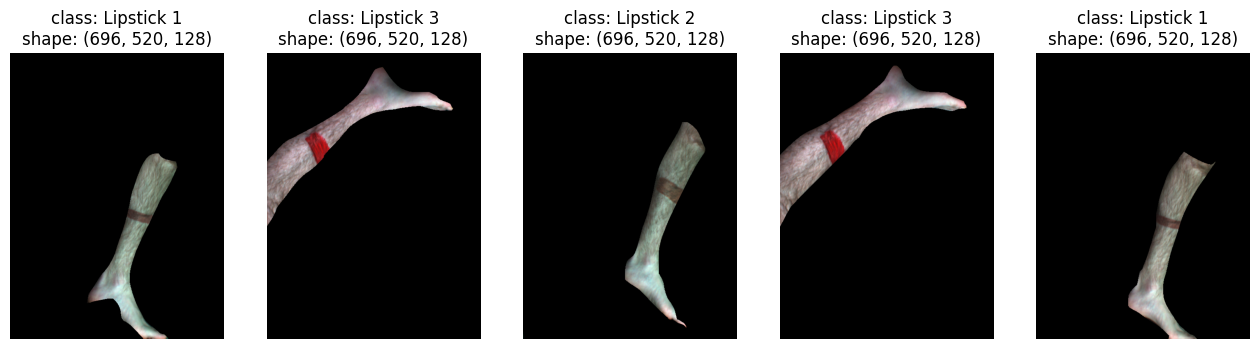

In [122]:
display_random_images(train_data_custom, #modified
                      n=5, 
                      classes=train_data_custom.classes,
                      seed=None)

______why are the above images different colors based on their class?

# Plot all of the images in a given folder for investigation of input data

There are 0 directories and 3 images in /Users/maycaj/Documents/Hyperspectral-Imaging_II/Lipstick Input/Train/Lipstick 1/


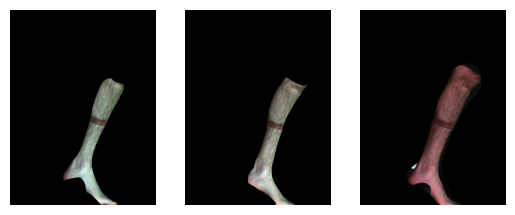

In [123]:
directory = '/Users/maycaj/Documents/Hyperspectral-Imaging_II/Lipstick Input/Train/Lipstick 1/'
def find_filepaths(directory):
    for dirpath, dirnames, filenames in os.walk(directory):
        print(f'There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}')
    filepaths = []
    for filename in filenames:
        filepath = directory + filename
        filepaths.append(filepath)
    return filepaths
filepaths = find_filepaths(directory)

for i, filepath in enumerate(filepaths):
    img = np.load(filepath)
    # Grab the colored bands
    red = img[:,:,20]
    green = img[:,:,35]
    blue = img[:,:,60]

    # Normalize the bands to [0, 1] for each color channel
    red = (red - np.min(red)) / (np.max(red) - np.min(red))
    green = (green - np.min(green)) / (np.max(green) - np.min(green))
    blue = (blue - np.min(blue)) / (np.max(blue) - np.min(blue))

    #Combine bands into color image
    color_img = np.dstack((blue,green,red))

    # Plot adjusted samples
    img_num = len(filepaths)
    plt.subplot(1, img_num, i+1)
    plt.imshow(color_img)
    plt.axis("off")


# **5.4** Turn custom loaded images into `DataLoader`'s

`DataLoader` wraps in iterable around the `Dataset` to enable easy access to the samples\
source: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

An *interable* in Python is an object that can be interated over

In [124]:
# Turn train and test custom Dataset's into DataLoader's
from torch.utils.data import DataLoader
train_dataloader_custom = DataLoader(dataset=train_data_custom, # use custom created train Dataset
                                     batch_size=1, # how many samples per batch?
                                     num_workers=0, # how many subprocesses to use for data loading? (higher = more)
                                                    # subprocesses are multiple processes, all loading data simultaneously
                                     shuffle=True) # shuffle the data?

test_dataloader_custom = DataLoader(dataset=test_data_custom, # use custom created test Dataset
                                    batch_size=1, 
                                    num_workers=0, 
                                    shuffle=False) # don't usually need to shuffle testing data

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x2a0a8bb50>,
 <torch.utils.data.dataloader.DataLoader at 0x2a0a8b8e0>)

In [125]:
# Get image and label from custom DataLoader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label_custom.shape}")

Image shape: torch.Size([1, 128, 520, 696]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


left off at 
https://www.learnpytorch.io/04_pytorch_custom_datasets/#7-model-0-tinyvgg-without-data-augmentation